<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Cats%20Vs%20Dogs/Resized%20cats%20vs%20dogs/Collab_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import pathlib


In [3]:
import os

print(os.listdir("/content/drive/My Drive/Gabor Dataset/"))

['cats-vs-dogs.zip']


In [4]:
!unzip /content/drive/My\ Drive/Gabor\ Dataset/cats-vs-dogs.zip -d cats-vs-dogs

Streaming output truncated to the last 5000 lines.
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.1234.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.6670.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.862.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.7225.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.4007.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.1698.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.4729.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.11973.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.5975.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.7848.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.11888.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.5743.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.4416.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.974.jpg  
  inflating: cats-vs-dogs/cats-vs-dogs/train/dog/dog.

In [6]:
import os

print(os.listdir("cats-vs-dogs/cats-vs-dogs/train/"))

['dog', 'cat']


In [3]:
data_dir = "cats-vs-dogs/cats-vs-dogs/train/"
img_size = 256
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, 
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


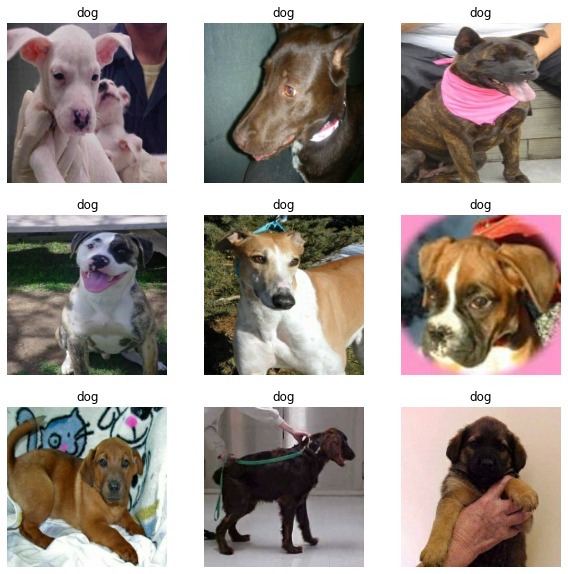

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 256, 256, 3)
(32,)


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [12]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [5]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam

num_classes = 2

classifier = Sequential([
    # layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    layers.Conv2D(32, kernel_size=(15,15), strides=(1,1), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),
    layers.Dense(num_classes)
])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 32)      21632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0

In [ ]:
# Fitting the CNN to the images

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import time

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)

stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)

classifier.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



epochs=10
start = time.perf_counter()
hist = classifier.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=[stop_alg, reduce_lr])
finish = time.perf_counter()

Epoch 1/10


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Binary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('cnn-gabor.cifar10.loss-2.png', dpi=350, bbox_inches='tight')
plt.show()

In [ ]:
print(start)
print(finish)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[1].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

# since there are 64 filters, we will display them 8x8
fig, axs = plt.subplots(8,8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (3,3,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("cnn-gabor.full.filters-2.png", bbox_inches='tight', dpi=350)

In [ ]:
cnnl1 = classifier.layers[1].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:


filenames = os.listdir("cats-vs-dogs/cats-vs-dogs/train/cat/") + os.listdir("cats-vs-dogs/cats-vs-dogs/train/dog/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})



In [4]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

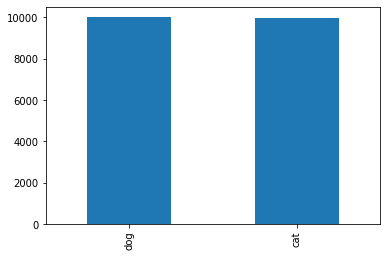

In [11]:
train_df['category'].value_counts().plot.bar()

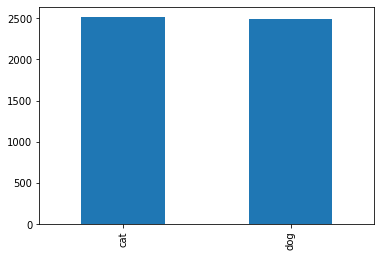

In [12]:
validate_df['category'].value_counts().plot.bar()

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,)